<a href="https://colab.research.google.com/github/mecuryD/story-generator/blob/main/story_generator_kogpt2_paragraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Do it! BERT와 GPT로 배우는 자연어 처리](https://github.com/ratsgo/ratsnlp/tree/master/ratsnlp/nlpbook) 를 많이 참고하였습니다

### **각종 설정하기**

In [1]:
# 의존성 패키지 설치
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Mounted at /content/drive/


In [3]:
# 모델 환경 설정
import os
import torch
from glob import glob
from dataclasses import dataclass, field

@dataclass
class TrainArguments :
    pretrained_model_name: str = field(default="skt/kogpt2-base-v2")
    downstream_task_name: str = field(default="sentence-generation")
    downstream_model_dir: str = field(default="/content/drive/MyDrive/Do-it-자연어처리/checkpoint-story")
    max_seq_length: int = field(default=32)
    save_top_k: int = field(default=1)
    monitor: str = field(default="min val_loss")
    epochs: int = field(default=3)
    batch_size: int = field(default=32)
    learning_rate: float = field(default=5e-5)
    seed: int = field(default=None, metadata={"help": "random seed."})
    overwrite_cache: bool = field(default=False, metadata={"help": "Overwrite the cached training and evaluation sets"})
    force_download: bool = field(default=False,metadata={"help": "force to download downstream data and pretrained models."})
    test_mode: bool = field(default=False,metadata={"help": "Test Mode enables `fast_dev_run`"})
    cpu_workers: int = field(default=os.cpu_count(),metadata={"help": "number of CPU workers"})
    fp16: bool = field(default=False,metadata={"help": "Enable train on FP16"})

In [4]:
args = TrainArguments(
    max_seq_length = 400,
    batch_size = 4 if torch.cuda.is_available() else 2,
    learning_rate = 5e-5,
    epochs=3,
    seed=7,
)

### **토크나이저 준비하기**

In [5]:
# 토크나이저 선언
from transformers import PreTrainedTokenizerFast
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
                                                    bos_token='</s>', eos_token='</s>', unk_token='<unk>', 
                                                    pad_token='<pad>', mask_token='<mask>')

print(tokenizer.tokenize("안녕하세요. 한국어 GPT-2 입니다.😤:)l^o"))

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


['▁안녕', '하', '세', '요.', '▁한국어', '▁G', 'P', 'T', '-2', '▁입', '니다.', '😤', ':)', 'l^o']


### **데이터 불러오기 / 전처리**

In [6]:
import os
import csv
import time
import torch
import logging
from filelock import FileLock
from dataclasses import dataclass
from typing import List, Optional
from torch.utils.data.dataset import Dataset
from transformers import PreTrainedTokenizerFast


@dataclass
class GenerationExample :
  text : str

@dataclass
class GenerationFeatures : 
  input_ids : List[int]
  attention_mask : Optional[List[int]] = None
  token_type_ids : Optional[List[int]] = None
  labels : Optional[List[int]] = None

In [7]:
def data_collator(features):
    """
    Very simple data collator that:
    - simply collates batches of dict-like objects
    - Performs special handling for potential keys named:
        - `label`: handles a single value (int or float) per object
        - `label_ids`: handles a list of values per object
    - does not do any additional preprocessing
    i.e., Property names of the input object will be used as corresponding inputs to the model.
    See glue and ner for example of how it's useful.
    """

    # In this function we'll make the assumption that all `features` in the batch
    # have the same attributes.
    # So we will look at the first element as a proxy for what attributes exist
    # on the whole batch.
    if not isinstance(features[0], dict):
        features = [vars(f) for f in features]

    first = features[0]
    batch = {}

    # Special handling for labels.
    # Ensure that tensor is created with the correct type
    # (it should be automatically the case, but let's make sure of it.)
    if "label" in first and first["label"] is not None:
        label = first["label"].item() if isinstance(first["label"], torch.Tensor) else first["label"]
        dtype = torch.long if isinstance(label, int) else torch.float
        batch["labels"] = torch.tensor([f["label"] for f in features], dtype=dtype)
    elif "label_ids" in first and first["label_ids"] is not None:
        if isinstance(first["label_ids"], torch.Tensor):
            batch["labels"] = torch.stack([f["label_ids"] for f in features])
        else:
            dtype = torch.long if type(first["label_ids"][0]) is int else torch.float
            batch["labels"] = torch.tensor([f["label_ids"] for f in features], dtype=dtype)

    # Handling of all other possible keys.
    # Again, we will use the first element to figure out which key/values are not None for this model.
    for k, v in first.items():
        if k not in ("label", "label_ids") and v is not None and not isinstance(v, str):
            if isinstance(v, torch.Tensor):
                batch[k] = torch.stack([f[k] for f in features])
            else:
                batch[k] = torch.tensor([f[k] for f in features], dtype=torch.long)

    return batch

In [8]:
'''Corpus'''
class StoryCorpus :
  def __init__(self, f_path) :
    # load raw data
    with open(f_path, "r", encoding="utf-8") as f :
      self.data = f.readlines()
    
    # create examples
    self.examples = self._create_examples(self.data)
    self.train = self.examples[:int(len(self.examples)*0.9)]
    self.valid = self.examples[int(len(self.examples)*0.9):]

  def _get_examples(self, mode) :
    if mode == 'train' :
      return self.train
    else : 
      return self.valid

  def _create_examples(self, lines) :
    examples = []
    for (i, line) in enumerate(lines) :
      examples.append(GenerationExample(text=line))
    return examples

'''Convert examples to features'''
def _convert_examples_to_generation_features(
    examples : List[GenerationExample],
    tokenizer, args):
  
  # tokenization
  batch_encoding = tokenizer(
      [example.text for example in examples],
      max_length = args.max_seq_length,
      padding = "max_length",
      truncation = True,
  )

  features = []
  for i in range(len(examples)) :
    inputs = {k:batch_encoding[k][i] for k in batch_encoding}
    feature = GenerationFeatures(**inputs,labels=batch_encoding["input_ids"][i])
    features.append(feature)
  
  for i, example in enumerate(examples[:5]) :
    print("*** Example ***")
    print("sentence : %s" % (example.text))
    print("tokens : %s" % (" ".join(tokenizer.convert_ids_to_tokens(features[i].input_ids))))
    print("features : %s" % features[i])

  return features

'''Dataset'''
class StoryDataset(Dataset) :
  def __init__(self, examples,args, tokenizer,mode,
               convert_examples_to_features_fn = _convert_examples_to_generation_features,):
    if examples is not None : 
      self.examples = examples
    else :
      raise KeyError("examples is not valid")

    # Load data features from dataset file
    print(f"Creating features from {mode}-examples")
    tokenizer.pad_token = tokenizer.eos_token
    self.features = convert_examples_to_features_fn(examples,tokenizer,args)

  def __len__(self) :
    return len(self.features)
  
  def __getitem__(self, i) :
    return self.features[i]

  def get_labels(self):
        return self.corpus.get_labels()

In [9]:
corpus = StoryCorpus("/content/drive/MyDrive/Do-it-자연어처리/data/grimm/fairy_tale_paragraph.txt")

# train data
train = corpus._get_examples('train')
print(train[0], "\n\n")
train_features = StoryDataset(train, args, tokenizer,'train', _convert_examples_to_generation_features)

GenerationExample(text='옛날 옛적에 소망을 이루어 주는 힘이 여전히 통했던 때에, 딸들이 모두 예쁜 왕이 한 분 살고 계셨어요.특히나 막내공주님이 아주 예뻤는데요, 어찌나 아름다운지, 해도 그녀의 얼굴에 햇볕을 비출 때마다 감탄을 하곤 하였더랬죠.왕의 성은 울창한 숲에 둘러싸여 있었어요.숲에 있는 나이 많은 라임 나무 아래에 우물이 하나 있었어요.화창한 날에, 막내공주님께서 숲으로 놀러 나와 시원한 분수 옆에 앉았어요.그녀는 따분할 땐 황금 공을 가져와 높이 던졌다가 다시 잡곤 했지요.황금 공놀이는 그녀가 가장 좋아하는 놀이었어요.그러다 우연히 공주의 작은 손으로 떠받치고 있던 황금 공이 바닥으로 떨어져 곧장 우물 속으로 굴러 들어갔지 뭐예요.공주님이 다급히 눈으론 공을 쫓았지만 허사였어요.우물은 꽤 깊었어요. 바닥이 보이지 않을 정도로요.\n') 


Creating features from train-examples
*** Example ***
sentence : 옛날 옛적에 소망을 이루어 주는 힘이 여전히 통했던 때에, 딸들이 모두 예쁜 왕이 한 분 살고 계셨어요.특히나 막내공주님이 아주 예뻤는데요, 어찌나 아름다운지, 해도 그녀의 얼굴에 햇볕을 비출 때마다 감탄을 하곤 하였더랬죠.왕의 성은 울창한 숲에 둘러싸여 있었어요.숲에 있는 나이 많은 라임 나무 아래에 우물이 하나 있었어요.화창한 날에, 막내공주님께서 숲으로 놀러 나와 시원한 분수 옆에 앉았어요.그녀는 따분할 땐 황금 공을 가져와 높이 던졌다가 다시 잡곤 했지요.황금 공놀이는 그녀가 가장 좋아하는 놀이었어요.그러다 우연히 공주의 작은 손으로 떠받치고 있던 황금 공이 바닥으로 떨어져 곧장 우물 속으로 굴러 들어갔지 뭐예요.공주님이 다급히 눈으론 공을 쫓았지만 허사였어요.우물은 꽤 깊었어요. 바닥이 보이지 않을 정도로요.

tokens : ▁옛날 ▁옛 적에 ▁소 망을 ▁이루어 ▁주는 ▁힘이 ▁여전히 ▁통 했던 ▁때에 , ▁딸 들이 ▁모두 ▁예쁜 ▁왕이 ▁한 ▁분 ▁살고 ▁계 셨 어

In [10]:
a = corpus.data

In [11]:
len(a)

1465

In [12]:
c = []
for i in a :
  c.append(int(len(tokenizer(i)['input_ids'])/10))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


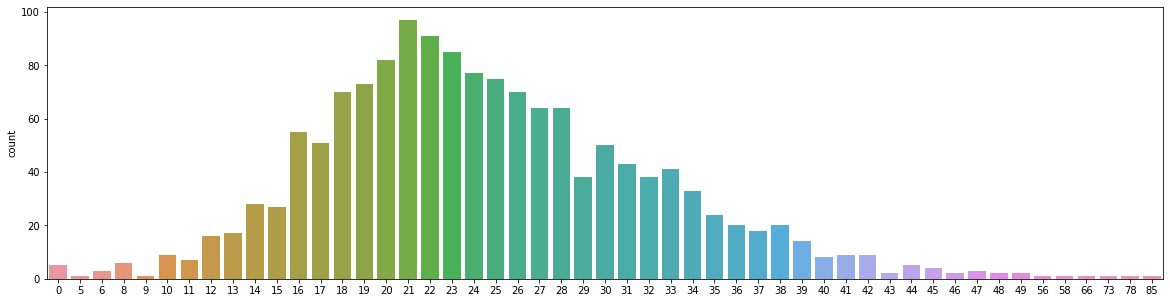

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
sns.countplot(c)

In [14]:
# validation data
valid = corpus._get_examples('valid')
print(valid[0], "\n\n")
valid_features = StoryDataset(valid, args, tokenizer,'valid', _convert_examples_to_generation_features)

GenerationExample(text='한스가 굳이 온힘을 다하지 않고도 두 서너 방 먹였더니 난쟁이가 계단 저 아래로 나가떨어지고 말았거든요.한스가 막 뒤쫓아 가려다 자신의 키가 너무 커 멈칫했지요, 잘못하면 계단에서 굴러떨어지니까요.그 바람에 난쟁이가 다시 일어났을 때엔 도망칠 여유가 생겼답니다.한스는 그럼에도 불구하고 숲 아주 깊숙이까지 난쟁이를 뒤쫓아 갔어요, 그때 난쟁이가 바위 속 구멍 안으로 쏙 미끄러져 들어가는 게 보이지 뭐예요.한스는 이제 집에 돌아왔지요. 하지만 표시를 해두고 오는 걸 잊이 않았답니다.다른 두 사람이 돌아왔을 때 그들은 한스가 멀쩡한 것을 보고 깜짝놀랐어요.무슨 일이 있었나를 한스가 그들에게 말해주었죠. 그래서 그들도 자신들이 당한 사실을 더는 숨기지 않았답니다.한스는 “껄껄걸” 웃으며 말했어요. “당해도 싸다, 그래 고기가 아까웠던 거야? 너희들 같이 이렇게 큰 애들이 그깟 난쟁이하나 당해내지 못해 얻어맞다니.”그런 까닭에 그들이 바구니와 새끼줄을 챙겨서, 난쟁이가 미끄러져 들어갔던 바위 속 구멍으로 가보았지요.그들은 우선 바구니에 한스와 한스의 방망이를 넣고 아래로 내렸어요.\n') 


Creating features from valid-examples
*** Example ***
sentence : 한스가 굳이 온힘을 다하지 않고도 두 서너 방 먹였더니 난쟁이가 계단 저 아래로 나가떨어지고 말았거든요.한스가 막 뒤쫓아 가려다 자신의 키가 너무 커 멈칫했지요, 잘못하면 계단에서 굴러떨어지니까요.그 바람에 난쟁이가 다시 일어났을 때엔 도망칠 여유가 생겼답니다.한스는 그럼에도 불구하고 숲 아주 깊숙이까지 난쟁이를 뒤쫓아 갔어요, 그때 난쟁이가 바위 속 구멍 안으로 쏙 미끄러져 들어가는 게 보이지 뭐예요.한스는 이제 집에 돌아왔지요. 하지만 표시를 해두고 오는 걸 잊이 않았답니다.다른 두 사람이 돌아왔을 때 그들은 한스가 멀쩡한 것을 보고 깜짝놀랐어요.무슨 일이 있었나를 한스가 그들에게 말해주었죠. 그래서 그들도 자신들이 당

In [15]:
# DataLoader
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
train_dataloader = DataLoader(train_features,
                              batch_size = args.batch_size,
                              sampler = RandomSampler(train, replacement=False),
                              collate_fn = data_collator,
                              drop_last = False,
                              num_workers = args.cpu_workers,)
val_dataloader = DataLoader(valid_features, 
                            batch_size = args.batch_size,
                            sampler = SequentialSampler(valid),
                            collate_fn = data_collator,
                            drop_last = True,
                            num_workers = args.cpu_workers,)

### **모델 초기화**

In [16]:
# 모델 준비
from transformers import GPT2LMHeadModel
model = GPT2LMHeadModel.from_pretrained("skt/kogpt2-base-v2")

### **파인 튜닝**

In [17]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.optim.lr_scheduler import ExponentialLR

# Define Task Module
class StoryGenerator(pl.LightningModule) :
  def __init__(self,model, args) :
    super().__init__()
    self.model = model
    self.args = args

  def configure_optimizers(self) :
    optimizer = optim.Adam(self.parameters(), lr=1e-3)
    scheduler = ExponentialLR(optimizer, gamma=0.9)
    return {'optimizer' : optimizer,
            'scheduler' : scheduler,
    }

  def training_step(self, inputs, batch_idx) :
    outputs = self.model(**inputs)
    self.log("loss", outputs.loss, prog_bar=False, logger=True, on_step=True, on_epoch=False)
    return outputs.loss

  def validation_step(self, inputs, batch_idx) :
    outputs = self.model(**inputs)
    self.log("val_loss", outputs.loss, prog_bar=True, logger=True, on_step=False, on_epoch=True)
    return outputs.loss

In [19]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

# Define Trainer function
def get_trainer(args,return_trainer_only=True) :
  ckpt_path = os.path.abspath(args.downstream_model_dir)
  os.makedirs(ckpt_path, exist_ok=True)

  # Checkpoint Callback
  checkpoint_callback = ModelCheckpoint(
      dirpath = ckpt_path, 
      filename = '{epoch}-{val_loss:.2f}',
      save_top_k = args.save_top_k,
      mode = args.monitor.split()[0], # "min"
      monitor = args.monitor.split()[1]  # "val_loss"
  )

  # Trainer
  trainer = Trainer(
      max_epochs = args.epochs,
      fast_dev_run = args.test_mode,
      num_sanity_val_steps = None if args.test_mode else 0,
      callbacks = [checkpoint_callback],
      default_root_dir = ckpt_path,

      # For GPU Setup
      deterministic=torch.cuda.is_available() and args.seed is not None,
      gpus = torch.cuda.device_count() if torch.cuda.is_available() else None,
      precision = 16 if args.fp16 else 32,
  )

  if return_trainer_only :
    return trainer
  else : 
    return checkpoint_callback, trainer

In [20]:
# Model
task = StoryGenerator(model, args)

# Fine-tuning
trainer = get_trainer(args)
trainer.fit(
    task,
    train_dataloaders = train_dataloader,
    val_dataloaders = val_dataloader,
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /content/drive/MyDrive/Do-it-자연어처리/checkpoint-story exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cu

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


### **인퍼런스**

In [21]:
text = '울창한 숲에 자신의 아내와 두 아이와 함께 힘들게 사는 어느 가난한 나무꾼이 있었어요'
input_ids = tokenizer.encode(text, return_tensors='pt')
gen_ids = model.generate(input_ids,
                           max_length=256,
                           repetition_penalty=3.0,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           use_cache=True)
generated = tokenizer.decode(gen_ids[0])
print(generated)

울창한 숲에 자신의 아내와 두 아이와 함께 힘들게 사는 어느 가난한 나무꾼이 있었어요? 그걸도 없었지요.그가 말했답니다.“오, 이건 네는 거예요, “여운 남자가 대답하세요.”그래서 그가 소리쳤습니다.하지만 그는 다시 데려다음날 아침은 그녀가 물었죠. 하지만 아빠, 저를 한 번 더 넌 내가 그를 데리고 갔어요.
</s>


In [22]:
text = '고양이 두 마리가 물고기를 사냥하고 있다.'
input_ids = tokenizer.encode(text, return_tensors='pt')
gen_ids = model.generate(input_ids,
                         do_sample=True,
                         max_length=128,
                         min_length=10,
                         top_p = 0.92,
                         repetition_penalty=1.5)
generated = tokenizer.decode(gen_ids[0])
print(generated)

고양이 두 마리가 물고기를 사냥하고 있다. 그 바람에 자신의 마리를 내려서 문을 열어졌어요.그녀들은 한 쪽 산에 나왔더니, 나무 위로 나오셨다 했는지 보따름꾼은 너무에도 난 그녀는 말했지 않잖아음날 그가 말을 보고,”그러더니 엄마님이 그를 다시 숲으로 갔죠. 그리고 큰 식탁이제게 되었답니다. 그래서 거예요!”그래도 물었어요.
</s>
